Episode 10/500: Duration = 41
Episode 20/500: Duration = 9
Episode 30/500: Duration = 8
Episode 40/500: Duration = 13
Episode 50/500: Duration = 12
Episode 60/500: Duration = 12
Episode 70/500: Duration = 15
Episode 80/500: Duration = 9
Episode 90/500: Duration = 10
Episode 100/500: Duration = 10
Episode 110/500: Duration = 10
Episode 120/500: Duration = 13
Episode 130/500: Duration = 13
Episode 140/500: Duration = 27
Episode 150/500: Duration = 34
Episode 160/500: Duration = 88
Episode 170/500: Duration = 97
Episode 180/500: Duration = 154
Episode 190/500: Duration = 117
Episode 200/500: Duration = 100
Episode 210/500: Duration = 83
Episode 220/500: Duration = 154
Episode 230/500: Duration = 138
Episode 240/500: Duration = 153
Episode 250/500: Duration = 154
Episode 260/500: Duration = 173
Episode 270/500: Duration = 150
Episode 280/500: Duration = 133
Episode 290/500: Duration = 140
Episode 300/500: Duration = 128
Episode 310/500: Duration = 138
Episode 320/500: Duration = 143
Episod

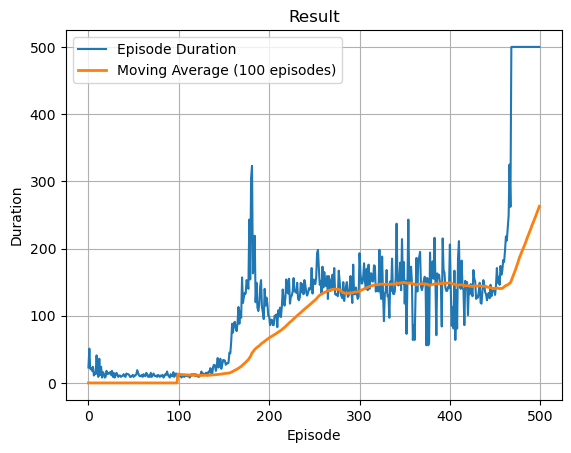

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
from itertools import count

# Neural Network for Double DQN
class DQNModel(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ExperienceReplay:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def add(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Utility Functions
def select_action(state, policy_net, steps_done, eps_start, eps_end, eps_decay, n_actions, device):
    eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1.0 * steps_done / eps_decay)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model_double_dqn(memory, policy_net, target_net, optimizer, gamma, batch_size, device):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)

    # Double DQN: Use policy network to select the best action, but evaluate it using the target network
    best_actions = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, best_actions).squeeze()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plotting
episode_durations = []

def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Result' if show_result else 'Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label='Episode Duration')

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='Moving Average (100 episodes)', linewidth=2)

    plt.legend()
    plt.grid(True)
    if show_result:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        plt.pause(0.001)

# Double DQN Training
def train_double_dqn(num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr, log_interval=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("CartPole-v1")
    num_actions = env.action_space.n
    state, _ = env.reset()
    num_observations = len(state)

    policy_net = DQNModel(num_observations, num_actions).to(device)
    target_net = DQNModel(num_observations, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
    memory = ExperienceReplay(10000)

    steps_done = 0
    for i_episode in tqdm(range(num_episodes), desc="Training: ", disable=True):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_duration = 0

        for t in count():
            action = select_action(state, policy_net, steps_done, eps_start, eps_end, eps_decay, num_actions, device)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            steps_done += 1
            episode_duration += 1

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            memory.add(state, action, next_state, reward)
            state = next_state

            optimize_model_double_dqn(memory, policy_net, target_net, optimizer, gamma, batch_size, device)

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(episode_duration)
                break

        if (i_episode + 1) % log_interval == 0:
            print(f"Episode {i_episode + 1}/{num_episodes}: Duration = {episode_durations[-1]}")

    plot_durations(episode_durations, show_result=True)
    plt.ioff()
    plt.show()

# Parameters
num_episodes = 500
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 1e-4

# Train the Double DQN
train_double_dqn(num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr)
